In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast, os
import matplotlib
import numpy as np

matplotlib.rcParams.update({'font.size': 14})

### Read in image directories

In [2]:
def read_img_dir(model='xl'):
    path = '/Users/josephking/Documents/sponsored_projects/MERGEN/data/pix2pix/MERGEN/test_'
    df = pd.read_csv(os.path.join(path, 'Bboxes_' + model + '.csv'), usecols=['Make', 'Model', 'Source Path', 'visible', 'Bboxes'])
    df['Bboxes'] = df['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
    return df

In [3]:
xl_img_dir = read_img_dir('xl')
lg_img_dir = read_img_dir('large')
med_img_dir = read_img_dir('medium')
sm_img_dir = read_img_dir('small')

# Share of images by model where no vehicle detected

In [4]:
no_veh_visible = []
for x in [sm_img_dir, med_img_dir, lg_img_dir, xl_img_dir]:
    temp = x[x['visible'] == True]
    total_visible = len(temp)
    temp = temp.loc[temp.Bboxes.str.len() != 0]
    no_veh_visible.append(1 - (len(temp) / total_visible))
    
no_veh_thermal = []
for x in [sm_img_dir, med_img_dir, lg_img_dir, xl_img_dir]:
    temp = x[x['visible'] == False]
    total_thermal = len(temp)
    temp = temp.loc[temp.Bboxes.str.len() != 0]
    no_veh_thermal.append(1 - (len(temp) / total_thermal))
    
# Adjust thermal by visible amount
no_veh_thermal = [i - j for i, j in zip(no_veh_thermal, no_veh_visible)]

labels = ['Small', 'Medium', 'Large', 'XL']

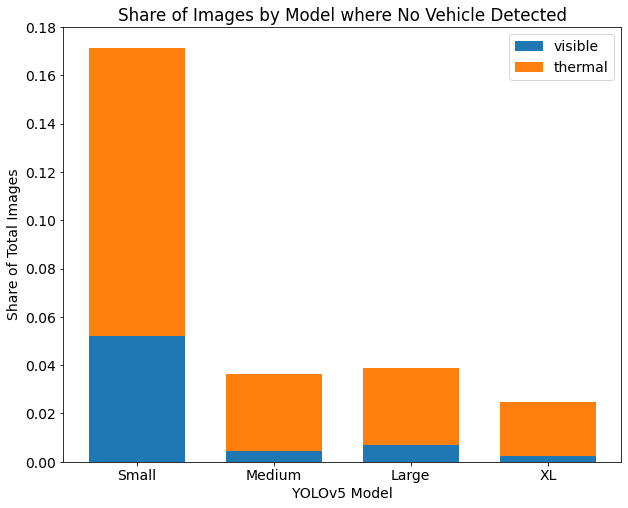

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.set_facecolor('white')
width = 0.7
ax.bar(labels, no_veh_visible, width, label='visible')
ax.bar(labels, no_veh_thermal, width, bottom=no_veh_visible, label='thermal')
plt.title('Share of Images by Model where No Vehicle Detected')
plt.xlabel('YOLOv5 Model')
plt.ylabel('Share of Total Images')
plt.legend()
plt.savefig('/Users/josephking/Desktop/export/share_no_vehicle_thermal_visible.png', dpi=200)
plt.show()

# Classification performance

In [6]:
# Paths to predictions/truth values for each
lg_thermal = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h36_lg_therm/logs/predicted_classes.csv'
lg_visible = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h39_lg_vis/logs/predicted_classes.csv'

xl_thermal = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h49_xl_therm/logs/predicted_classes.csv'
xl_visible = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h40_xl_vis/logs/predicted_classes.csv'

sm_thermal = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h51_sm_therm/logs/predicted_classes.csv'
sm_visible = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h52_sm_vis/logs/predicted_classes.csv'

med_thermal = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h56_med_therm/logs/predicted_classes.csv'
med_visible = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h53_med_vis/logs/predicted_classes.csv'

In [7]:
argmax0 = []
argmax4 = []

for x in [sm_thermal, sm_visible, med_thermal, med_visible, lg_thermal, lg_visible, xl_thermal, xl_visible]:
    
    temp = pd.read_csv(x, usecols=['true_label', 'Argmax(0)', 'Argmax(1)', 'Argmax(2)', 'Argmax(3)', 'Argmax(4)'])
    
    true = temp['true_label']
    del temp['true_label']
    
    # Calculate cumulative accuracy
    accuracy = temp.apply(lambda x: true == x)
    accuracy = accuracy.mean().cumsum()
    
    argmax0.append(accuracy.tolist()[0])
    argmax4.append(accuracy.tolist()[4])
    
# Adjust argmax4 by argmax0 amount
argmax4 = [i - j for i, j in zip(argmax4, argmax0)]

labels = ['Sm Therm', 'Sm Vis', 'Med Therm', 'Med Vis', 'Lg Therm', 'Lg Vis', 'XL Therm', 'XL Vis']

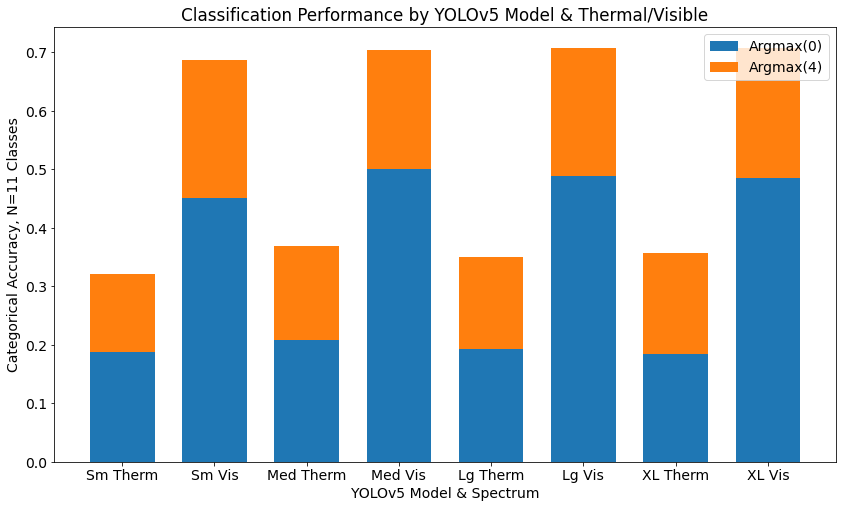

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))
fig.set_facecolor('white')
width = 0.7
ax.bar(labels, argmax0, width, label='Argmax(0)')
ax.bar(labels, argmax4, width, bottom=argmax0, label='Argmax(4)')
plt.title('Classification Performance by YOLOv5 Model & Thermal/Visible')
plt.xlabel('YOLOv5 Model & Spectrum')
plt.ylabel('Categorical Accuracy, N=11 Classes')
plt.legend()
plt.savefig('/Users/josephking/Desktop/export/class_perform_therm_vis.png', dpi=200)
plt.show()

# Confidence by model

In [9]:
sm_img_dir = sm_img_dir[sm_img_dir.Bboxes.str.len() != 0]
med_img_dir = med_img_dir[med_img_dir.Bboxes.str.len() != 0]
lg_img_dir = lg_img_dir[lg_img_dir.Bboxes.str.len() != 0]
xl_img_dir = xl_img_dir[xl_img_dir.Bboxes.str.len() != 0]

In [10]:
for x in [sm_img_dir, med_img_dir, lg_img_dir, xl_img_dir]:
    x['conf'] = x['Bboxes'].apply(lambda x: x[-1])

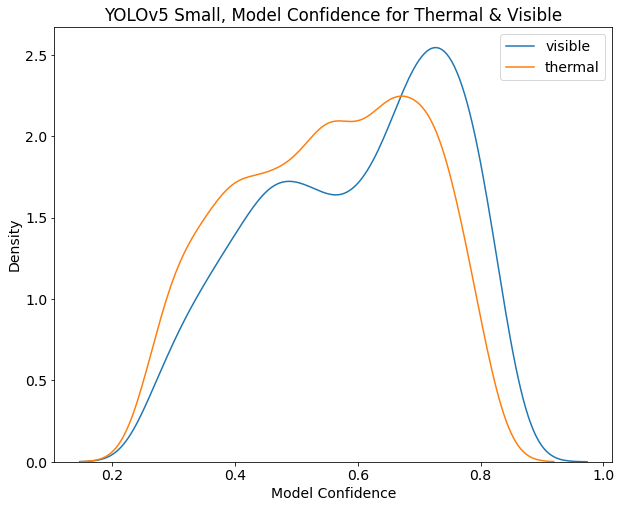

In [11]:
figure(figsize=(10, 8))
sns.kdeplot(sm_img_dir[sm_img_dir.visible == True]['conf'], label='visible')
sns.kdeplot(sm_img_dir[sm_img_dir.visible == False]['conf'], label='thermal')
plt.xlabel('Model Confidence')
plt.title('YOLOv5 Small, Model Confidence for Thermal & Visible')
plt.legend()
plt.show()

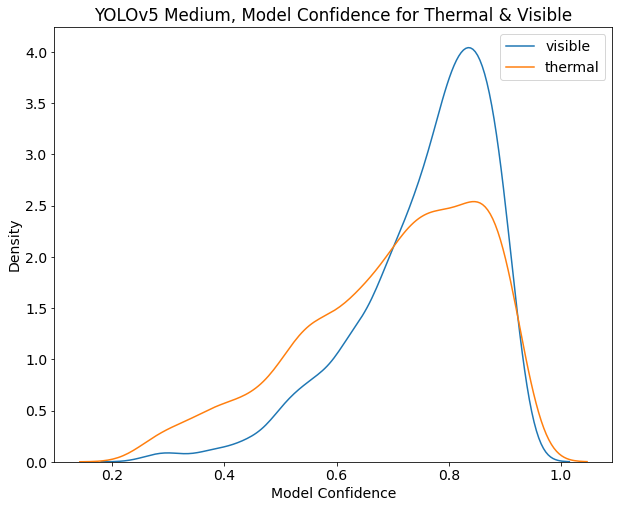

In [12]:
ax = figure(figsize=(10, 8))
ax.set_facecolor('white')
sns.kdeplot(med_img_dir[med_img_dir.visible == True]['conf'], label='visible')
sns.kdeplot(med_img_dir[med_img_dir.visible == False]['conf'], label='thermal')
plt.xlabel('Model Confidence')
plt.title('YOLOv5 Medium, Model Confidence for Thermal & Visible')
plt.legend()
plt.savefig('/Users/josephking/Desktop/export/kdeplot_yolo_medium_confidence_thermal_visible.png', dpi=200)
plt.show()

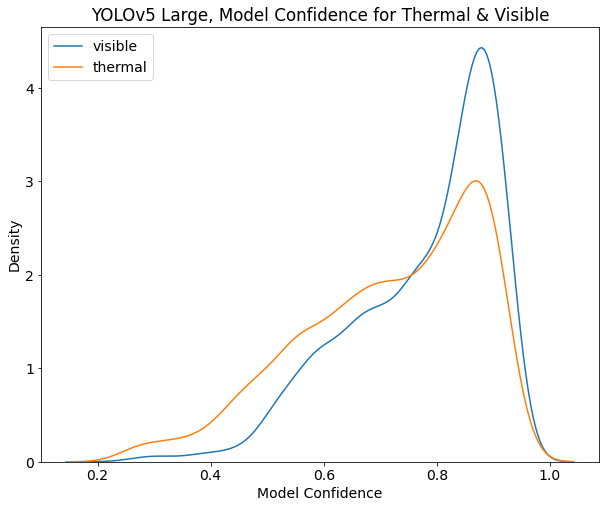

In [13]:
figure(figsize=(10, 8))
sns.kdeplot(lg_img_dir[lg_img_dir.visible == True]['conf'], label='visible')
sns.kdeplot(lg_img_dir[lg_img_dir.visible == False]['conf'], label='thermal')
plt.xlabel('Model Confidence')
plt.title('YOLOv5 Large, Model Confidence for Thermal & Visible')
plt.legend()
plt.show()

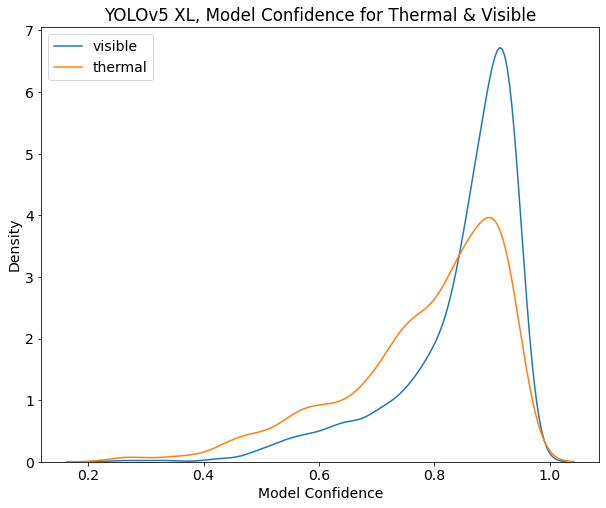

In [14]:
figure(figsize=(10, 8))
sns.kdeplot(xl_img_dir[xl_img_dir.visible == True]['conf'], label='visible')
sns.kdeplot(xl_img_dir[xl_img_dir.visible == False]['conf'], label='thermal')
plt.xlabel('Model Confidence')
plt.title('YOLOv5 XL, Model Confidence for Thermal & Visible')
plt.legend()
plt.show()

# Intersection over Union (IoU)

In [15]:
def bb_intersection_over_union(boxA, boxB):
    # Credit: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [16]:
def group_mean(dataframe, model='sm', round_places=3):
    
    df = dataframe[[f"conf_{model}", f"iou_{model}_xl"]].copy()
    df[f"conf_{model}"] = round(df[f"conf_{model}"], round_places)
    return df.groupby(f"conf_{model}")[f"iou_{model}_xl"].mean().reset_index().rename(columns={f"conf_{model}": 'conf'})

In [17]:
bbox = pd.DataFrame(pd.concat([sm_img_dir['Source Path'], med_img_dir['Source Path'], lg_img_dir['Source Path'], xl_img_dir['Source Path']], 
                                   axis=0).drop_duplicates().reset_index(drop=True), columns=['Source Path'])

bbox = bbox.merge(sm_img_dir[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'sm', 'conf': 'conf_sm'}), on='Source Path', how='left')
bbox = bbox.merge(med_img_dir[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'med', 'conf': 'conf_med'}), on='Source Path', how='left')
bbox = bbox.merge(lg_img_dir[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'lg', 'conf': 'conf_lg'}), on='Source Path', how='left')
bbox = bbox.merge(xl_img_dir[['Source Path', 'Bboxes', 'conf']].rename(columns={'Bboxes': 'xl', 'conf': 'conf_xl'}), on='Source Path', how='left')
bbox = bbox.dropna(axis=0).reset_index(drop=True)
bbox['visible'] = bbox['Source Path'].apply(lambda x: ''.join(x.split('/')[0]))
bbox['visible'] = np.where(bbox['visible'] == 'visible', True, False)

In [18]:
# Get IoU relative to XL model
bbox['iou_sm_xl'] = bbox.apply(lambda x: bb_intersection_over_union(x.sm, x.xl), axis=1)
bbox['iou_med_xl'] = bbox.apply(lambda x: bb_intersection_over_union(x.med, x.xl), axis=1)
bbox['iou_lg_xl'] = bbox.apply(lambda x: bb_intersection_over_union(x.lg, x.xl), axis=1)

In [19]:
therm = bbox[bbox.visible == False]
vis = bbox[bbox.visible == True]

In [20]:
therm_agg = group_mean(therm, 'sm')
for x in ['med', 'lg']:
    temp = group_mean(therm, x)
    therm_agg = therm_agg.merge(temp, on='conf', how='outer')
therm_agg = therm_agg.dropna(axis=0)
therm_agg = therm_agg.sort_values(by=['conf'])
therm_agg = therm_agg.set_index('conf')

vis_agg = group_mean(vis, 'sm')
for x in ['med', 'lg']:
    temp = group_mean(therm, x)
    vis_agg = vis_agg.merge(temp, on='conf', how='outer')
vis_agg = vis_agg.dropna(axis=0)
vis_agg = vis_agg.sort_values(by=['conf'])
vis_agg = vis_agg.set_index('conf')

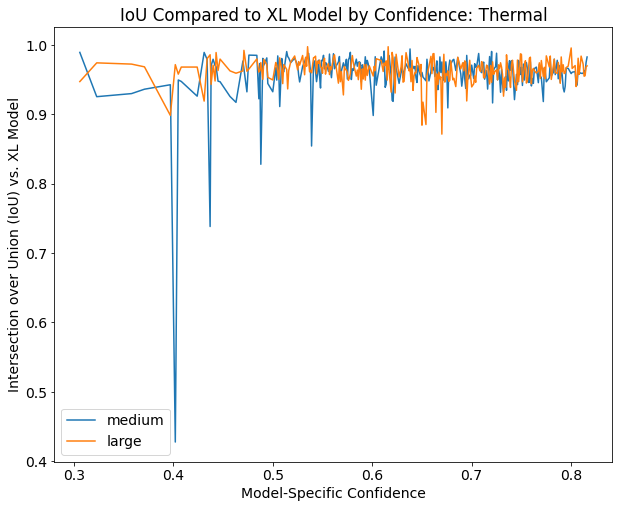

In [21]:
ax = figure(figsize=(10, 8))
ax.set_facecolor('white')
plt.plot(therm_agg['iou_med_xl'], label='medium')
plt.plot(therm_agg['iou_lg_xl'], label='large')
plt.legend()
plt.xlabel('Model-Specific Confidence')
plt.ylabel('Intersection over Union (IoU) vs. XL Model')
plt.title('IoU Compared to XL Model by Confidence: Thermal')
plt.show()

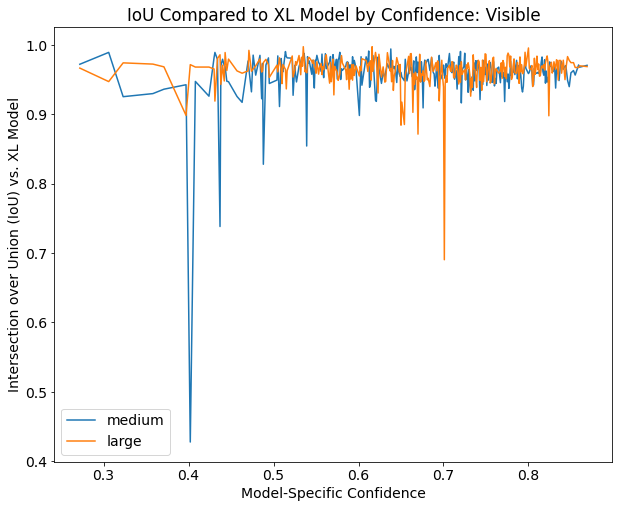

In [22]:
ax = figure(figsize=(10, 8))
ax.set_facecolor('white')
plt.plot(vis_agg['iou_med_xl'], label='medium')
plt.plot(vis_agg['iou_lg_xl'], label='large')
plt.legend()
plt.xlabel('Model-Specific Confidence')
plt.ylabel('Intersection over Union (IoU) vs. XL Model')
plt.title('IoU Compared to XL Model by Confidence: Visible')
plt.show()